In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import urllib2
import urllib
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import json
import re
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split  
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.neighbors import KNeighborsClassifier

WeatherData = pd.read_csv("./Weather Data.csv");
WeatherData = pd.DataFrame(data = WeatherData)
CrimeData = pd.read_csv("./Crime Data.csv");
CrimeData = pd.DataFrame(data = CrimeData)
sns.__version__

/anaconda2/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a 2.7.x release that supports hmac.compare_digest as soon as possible.
  utils.DeprecatedIn23,


'0.9.0'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11521 entries, 0 to 11520
Data columns (total 8 columns):
Date                      365 non-null object
HOURLYVISIBILITY          365 non-null float64
HOURLYDRYBULBTEMPF        365 non-null float64
HOURLYRelativeHumidity    365 non-null float64
HOURLYWindSpeed           365 non-null float64
HOURLYStationPressure     365 non-null float64
DAILYSunrise              365 non-null float64
DAILYSunset               365 non-null float64
dtypes: float64(7), object(1)
memory usage: 720.1+ KB
None


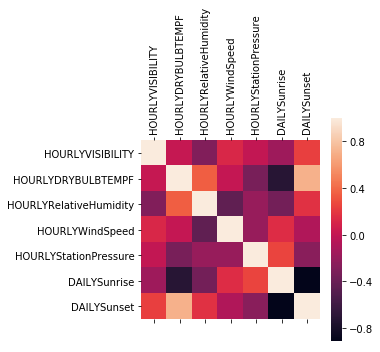

In [3]:
print WeatherData.info()

plt.matshow(WeatherData.corr())
corr = WeatherData.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [5]:

names = list(CrimeData)
#time_to_float can only be ran once
i = 0;
def time_to_float(time_str):
    time_str = str(time_str)
    return float(time_str.replace(":",""))
CrimeData['occur_time'] = CrimeData['occur_time'].apply(time_to_float)
print CrimeData.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26748 entries, 0 to 26747
Data columns (total 10 columns):
Date                26748 non-null object
occur_time          26748 non-null float64
poss_date           26748 non-null object
poss_time           26745 non-null object
MaxOfnum_victims    26748 non-null int64
Avg Day             26748 non-null object
UC2 Literal         26748 non-null object
neighborhood        25563 non-null object
x                   26748 non-null float64
y                   26748 non-null float64
dtypes: float64(3), int64(1), object(6)
memory usage: 2.0+ MB
None


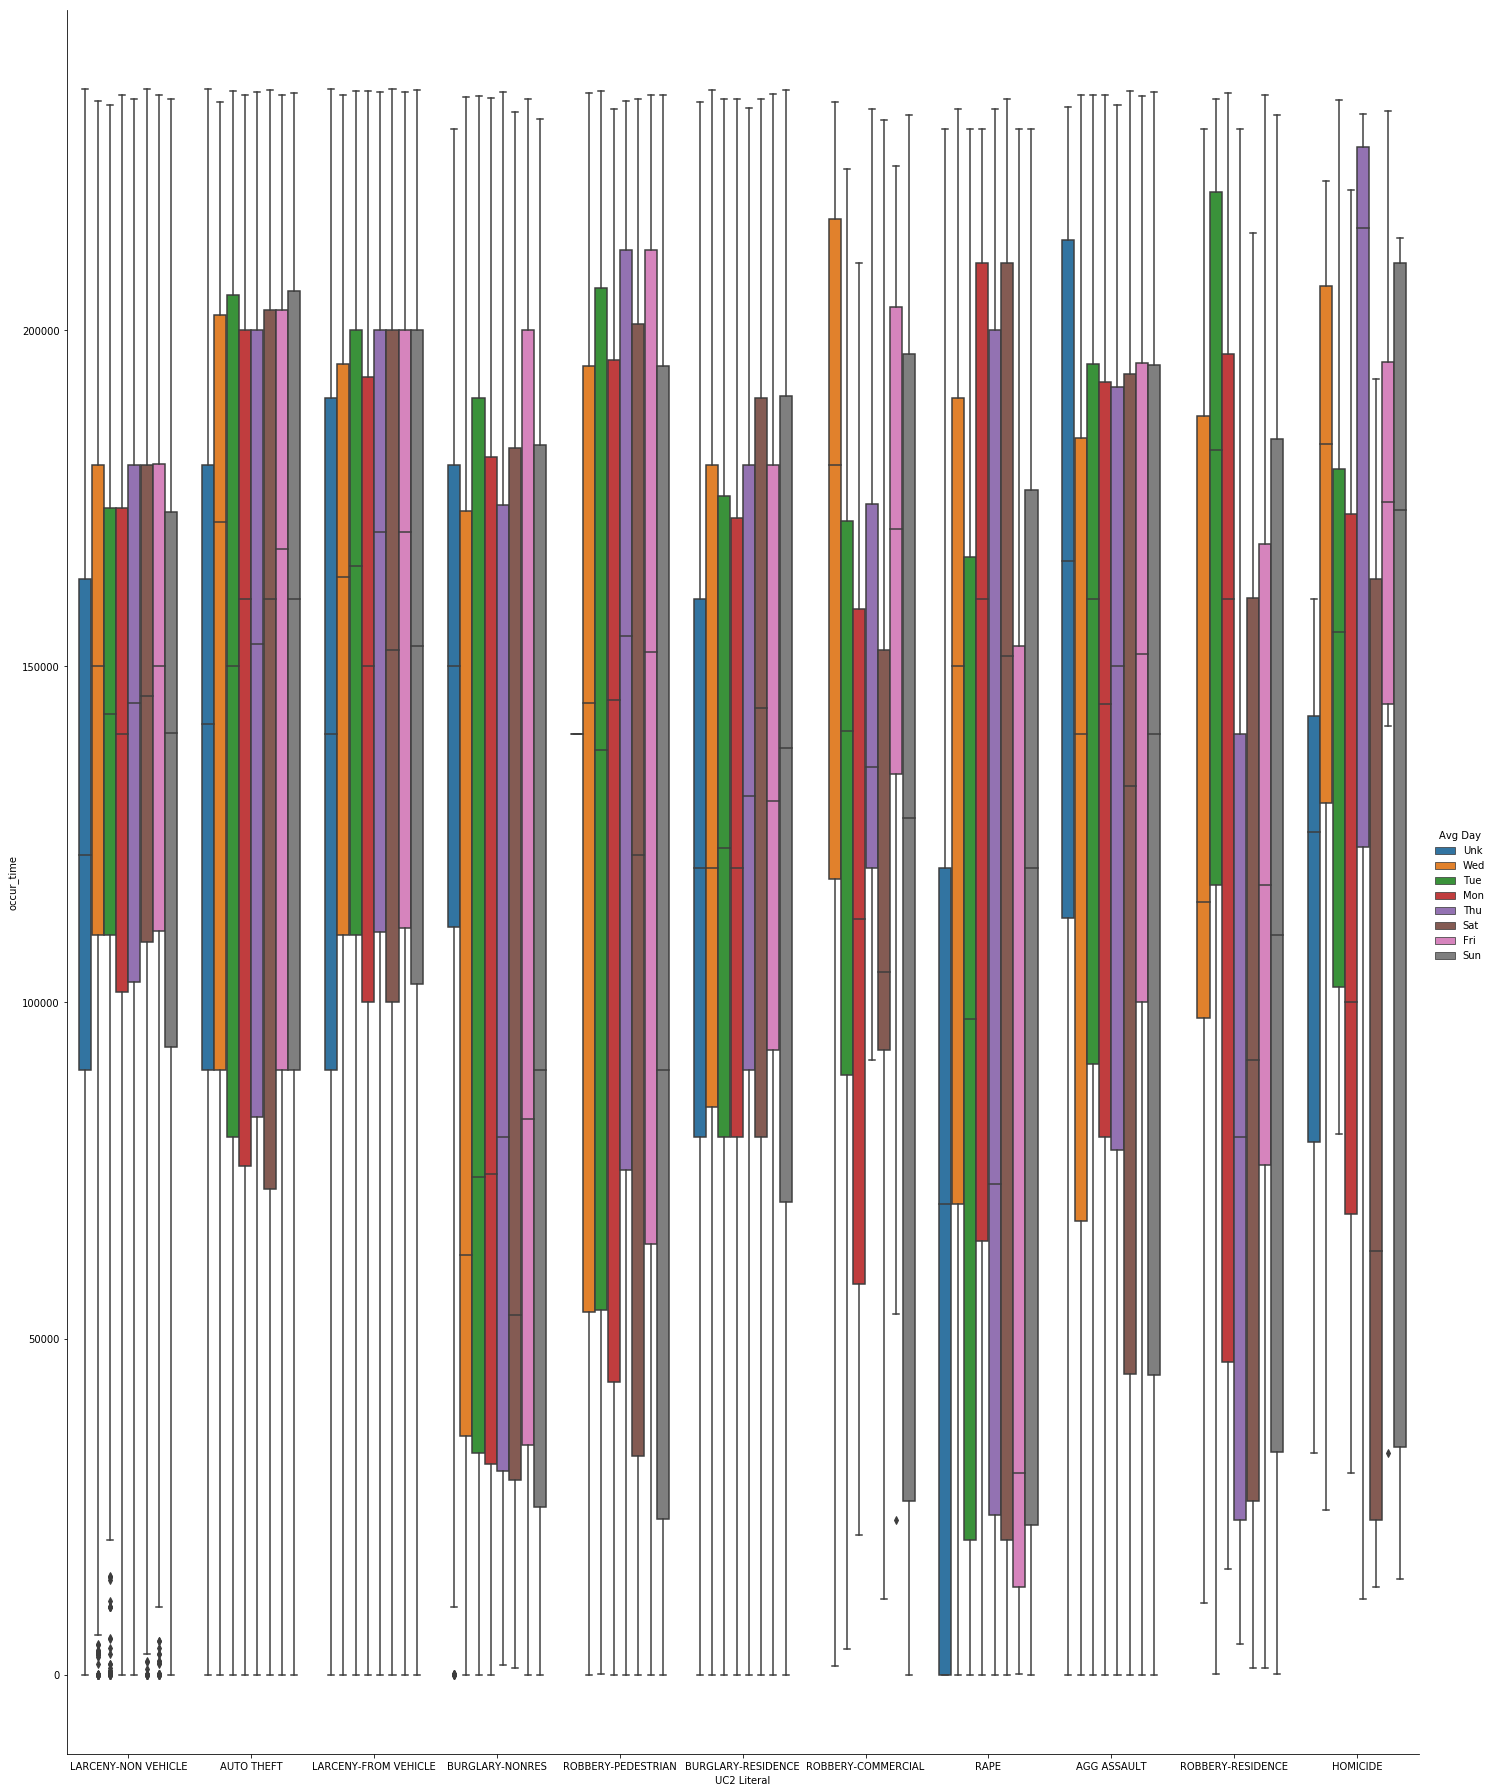

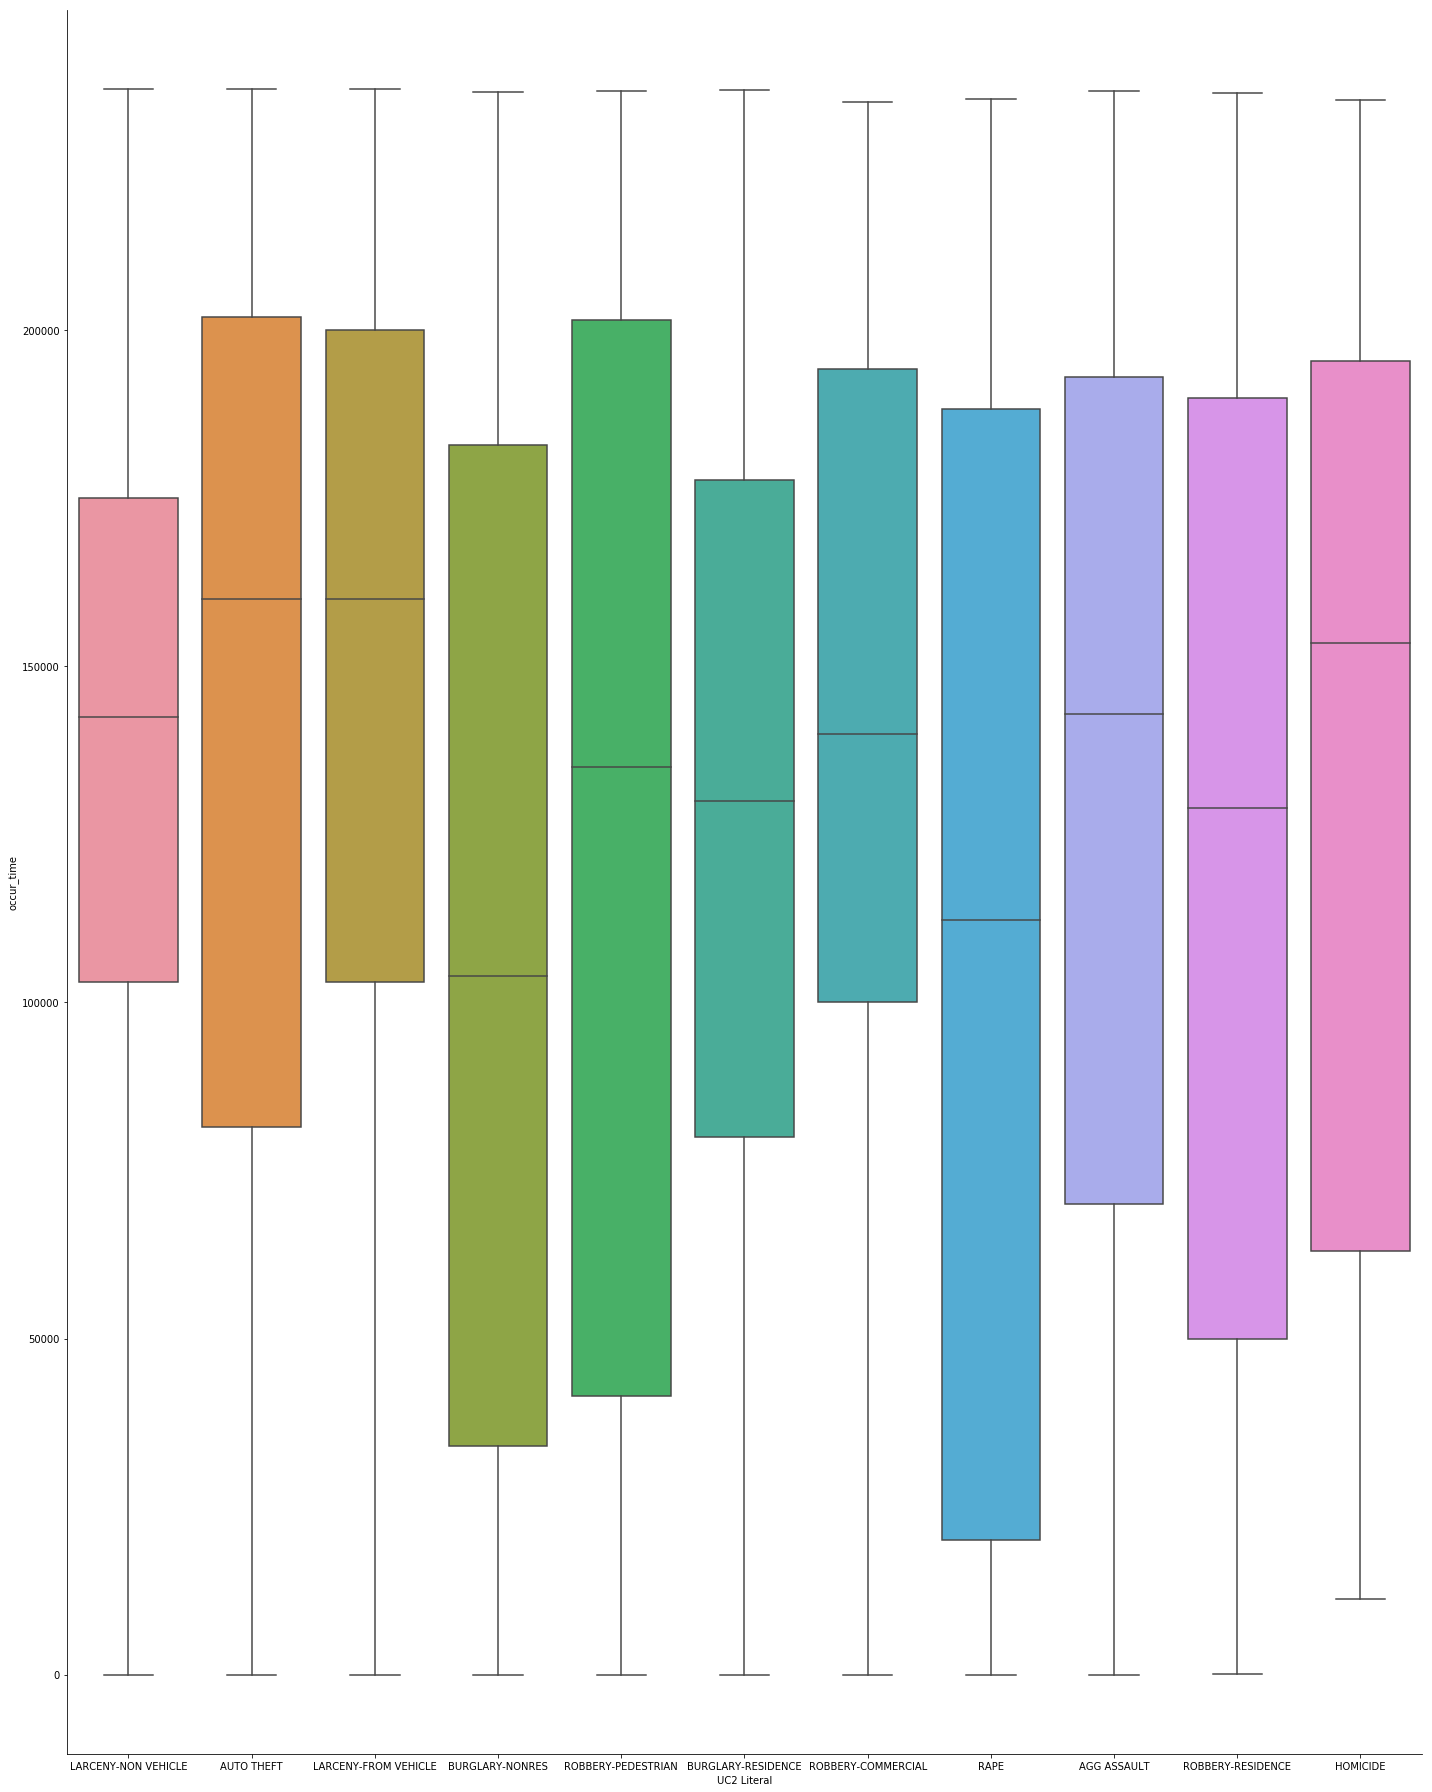

In [9]:
sns_plot = sns.catplot(x="UC2 Literal", y="occur_time", hue="Avg Day", kind = 'box', data=CrimeData, height = 25, aspect = .8);
sns_plot.savefig("dayBox.png")
sns_plot = sns.catplot(x="UC2 Literal", y="occur_time", kind = 'box', data=CrimeData, height = 25, aspect = .8);
sns_plot.savefig("timeBox.png")

In [11]:
CrimeWeatherData = [CrimeData, WeatherData]
CrimeWeatherData = CrimeData.merge(WeatherData,how='left', left_on='Date', right_on='Date')
CrimeWeatherData = CrimeWeatherData[pd.notnull(CrimeWeatherData['Date'])]
print CrimeWeatherData.info()
print CrimeWeatherData

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26748 entries, 0 to 26747
Data columns (total 17 columns):
Date                      26748 non-null object
occur_time                26748 non-null float64
poss_date                 26748 non-null object
poss_time                 26745 non-null object
MaxOfnum_victims          26748 non-null int64
Avg Day                   26748 non-null object
UC2 Literal               26748 non-null object
neighborhood              25563 non-null object
x                         26748 non-null float64
y                         26748 non-null float64
HOURLYVISIBILITY          26748 non-null float64
HOURLYDRYBULBTEMPF        26748 non-null float64
HOURLYRelativeHumidity    26748 non-null float64
HOURLYWindSpeed           26748 non-null float64
HOURLYStationPressure     26748 non-null float64
DAILYSunrise              26748 non-null float64
DAILYSunset               26748 non-null float64
dtypes: float64(10), int64(1), object(6)
memory usage: 3.7+ MB
Non

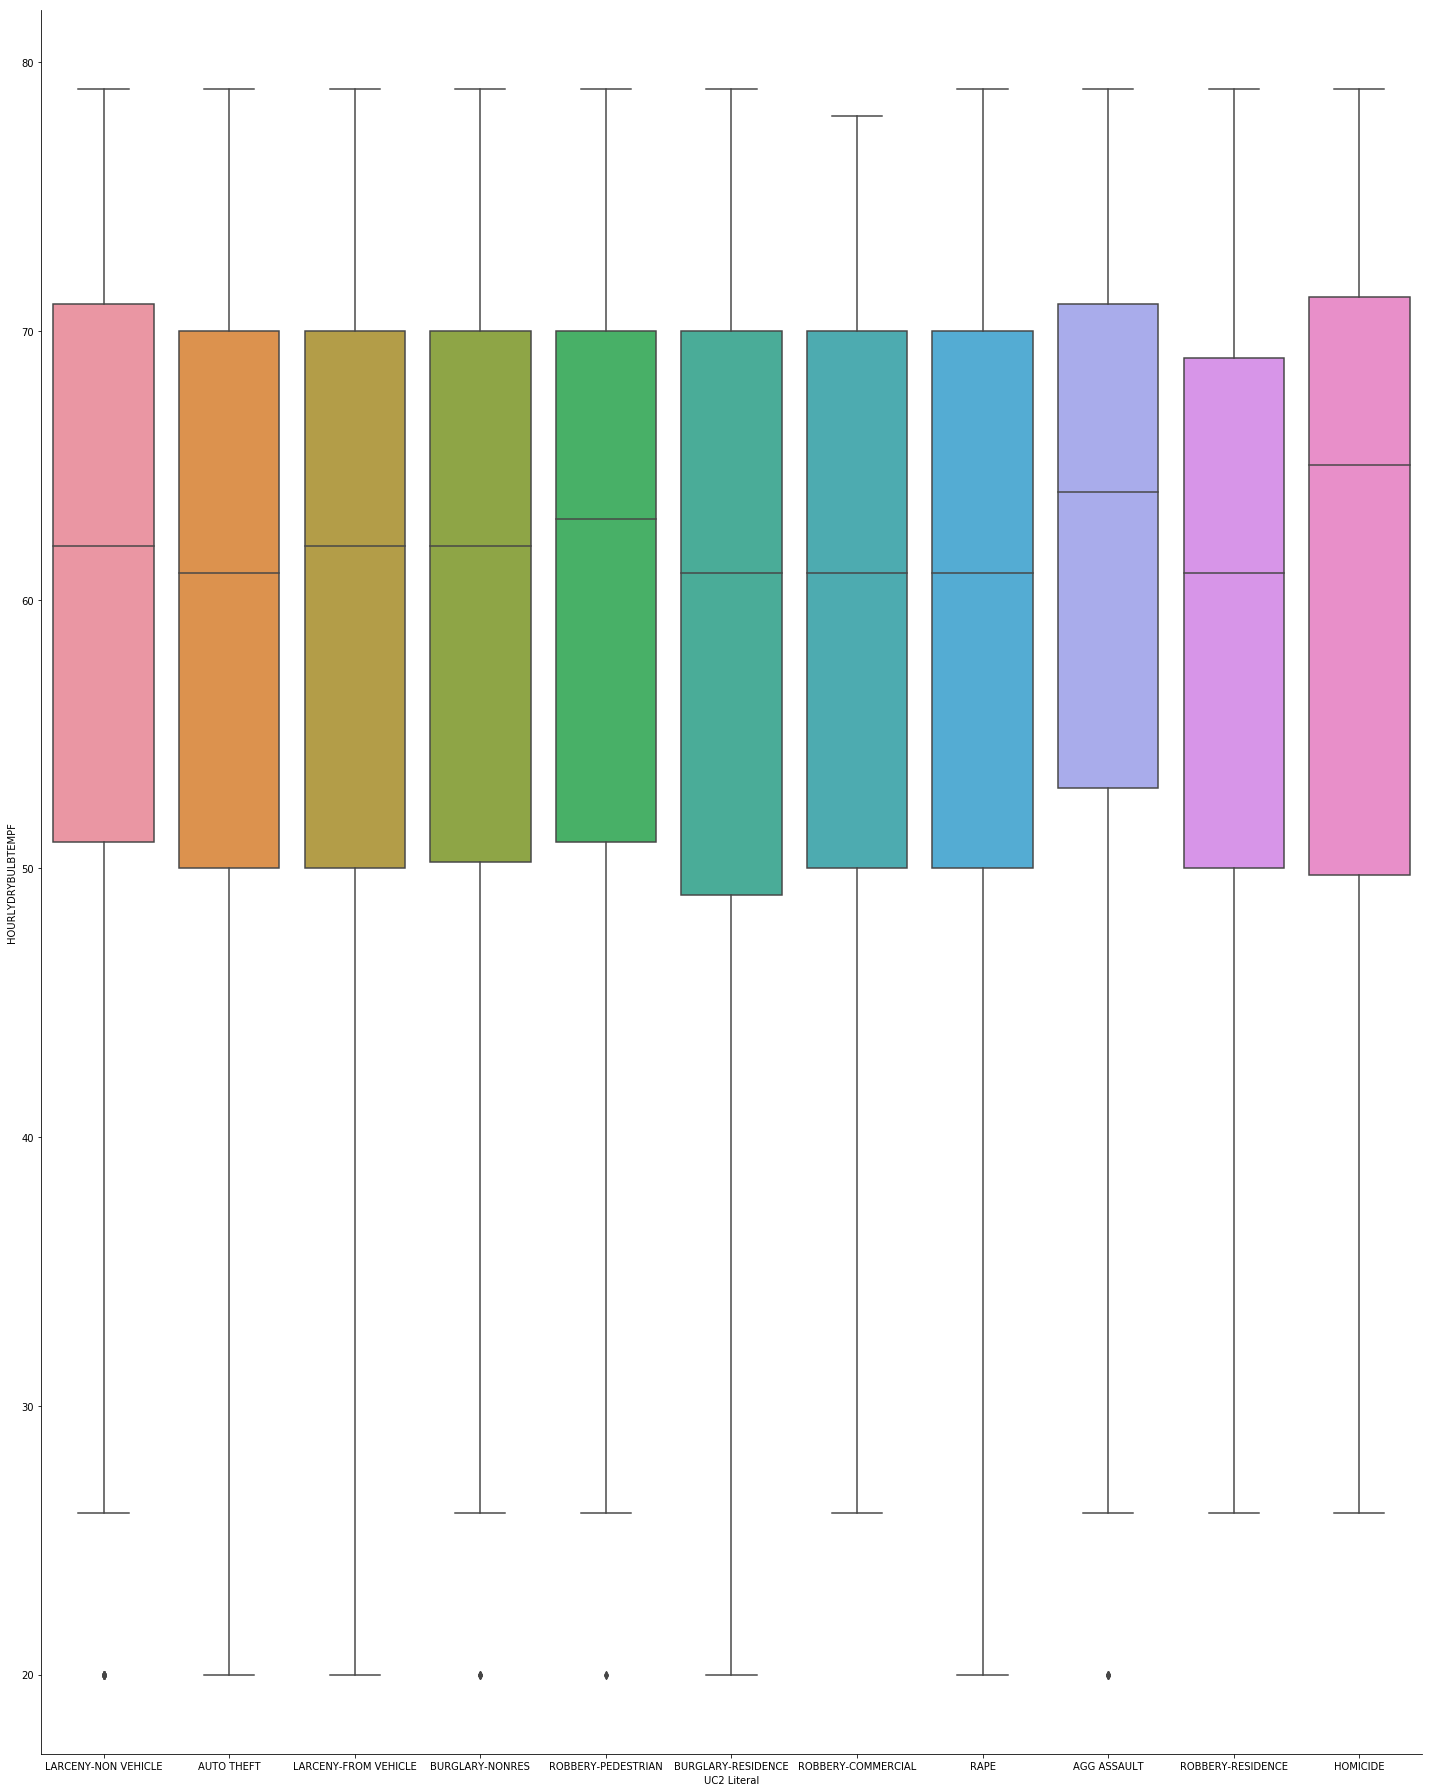

In [12]:
sns_plot = sns.catplot(x="UC2 Literal", y="HOURLYDRYBULBTEMPF", kind = 'box', data=CrimeWeatherData, height = 25, aspect = .8);
sns_plot.savefig("tempCrimeBox.png")

In [7]:
#Shuffle the Data to Do Predictive Analysis
CrimeWeatherData = CrimeWeatherData.sample(frac=1)
print CrimeWeatherData

           Date  occur_time poss_date poss_time  MaxOfnum_victims Avg Day  \
21882  10/26/17    201000.0  10/26/17  20:18:00               1.0     Thu   
1132    9/24/17      3400.0   9/24/17   0:50:00               7.0     Sun   
21416   7/24/17    200000.0   7/24/17  17:30:00               1.0     Mon   
1977     7/8/17     13500.0    7/8/17   1:44:00               1.0     Sat   
14270    5/9/17    153000.0    5/9/17   7:00:00               1.0     Mon   
6696   12/20/17     92000.0  12/20/17   9:31:00               1.0     Wed   
24318    9/5/17    220000.0    9/5/17   7:30:00               1.0     Tue   
19260   5/11/17    185300.0   5/11/17  19:06:00               1.0     Thu   
582    10/17/17       100.0  10/17/17  12:13:00               1.0     Tue   
4439    1/21/17     63000.0   1/21/17   6:33:00               1.0     Sat   
10988    7/5/17    130000.0    7/5/17  20:00:00               1.0     Wed   
19568    9/7/17    190000.0    9/7/17  20:11:00               4.0     Thu   

In [28]:

CrimeWeatherData['Avg Day'] = CrimeWeatherData['Avg Day'].astype('category')
CrimeWeatherData['Avg Day'] = CrimeWeatherData['Avg Day'].cat.codes
CrimeWeatherData['UC2 Literal'] = CrimeWeatherData['UC2 Literal'].astype('category')
CrimeWeatherData['UC2 Literal'] = CrimeWeatherData['UC2 Literal'].cat.codes
print CrimeWeatherData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26748 entries, 0 to 26747
Data columns (total 17 columns):
Date                      26748 non-null object
occur_time                26748 non-null float64
poss_date                 26748 non-null object
poss_time                 26745 non-null object
MaxOfnum_victims          26748 non-null int64
Avg Day                   26748 non-null int8
UC2 Literal               26748 non-null int8
neighborhood              25563 non-null object
x                         26748 non-null float64
y                         26748 non-null float64
HOURLYVISIBILITY          26748 non-null float64
HOURLYDRYBULBTEMPF        26748 non-null float64
HOURLYRelativeHumidity    26748 non-null float64
HOURLYWindSpeed           26748 non-null float64
HOURLYStationPressure     26748 non-null float64
DAILYSunrise              26748 non-null float64
DAILYSunset               26748 non-null float64
dtypes: float64(10), int64(1), int8(2), object(4)
memory usage: 3.3+ M

## Can we predict crime type based on temperature?

In [18]:
#Model: KNN
#separate into training and testing models. 80% used for training each model, 20% for testing
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(CrimeWeatherData['HOURLYDRYBULBTEMPF'], CrimeWeatherData['UC2 Literal'], test_size=0.20)
X_train = X_train.values
X_train = X_train.reshape(-1, 1)
y_train = y_train.values
y_train = y_train.reshape(-1, 1)

X_test = X_test.values
X_test = X_test.reshape(-1, 1)
y_test = y_test.values
y_test = y_test.reshape(-1, 1)

classifier = KNeighborsClassifier(n_neighbors=5)  
classifier.fit(X_train, y_train)  
y_pred = classifier.predict(X_test)  

print classifier.score(X_test,y_test)
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred))  

0.2611214953271028
[[ 30  56   1  36   0 198  82   0   0  21   0]
 [ 39 108   1  41   0 291 127   0   0  21   0]
 [  9  21   1   6   0  59  32   0   0   6   0]
 [ 40  75   1  37   0 249  99   0   0  19   0]
 [  1   1   0   1   0   7   6   0   0   2   0]
 [120 312   5 119   0 932 370   0   0  76   0]
 [ 86 203   6  85   0 627 277   0   0  44   0]
 [  1   7   0   6   0  21  15   0   0   2   0]
 [  2   4   0   3   0  21   3   0   0   2   0]
 [ 12  39   0  14   0 128  44   0   0  12   0]
 [  1   5   0   2   0  14   5   0   0   1   0]]
             precision    recall  f1-score   support

          0       0.09      0.07      0.08       424
          1       0.13      0.17      0.15       628
          2       0.07      0.01      0.01       134
          3       0.11      0.07      0.09       520
          4       0.00      0.00      0.00        18
          5       0.37      0.48      0.42      1934
          6       0.26      0.21      0.23      1328
          7       0.00      0.00      

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  app.launch_new_instance()
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
#Model: RandomForest
X_train, X_test, y_train, y_test = train_test_split(CrimeWeatherData['HOURLYDRYBULBTEMPF'], CrimeWeatherData['UC2 Literal'], test_size=0.20)
X_train = X_train.values
X_train = X_train.reshape(-1, 1)
y_train = y_train.values
y_train = y_train.reshape(-1, 1)

X_test = X_test.values
X_test = X_test.reshape(-1, 1)
y_test = y_test.values
y_test = y_test.reshape(-1, 1)

RFC = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
RFC.fit(X_train,y_train)
y_pred2 = RFC.predict(X_test)
print "Accuracy Score: "
print RFC.score(X_test,y_test)
print(confusion_matrix(y_test, y_pred2))  
print(classification_report(y_test, y_pred2))  

In [15]:
#Model: DecisionTree
X_train, X_test, y_train, y_test = train_test_split(CrimeWeatherData['HOURLYDRYBULBTEMPF'], CrimeWeatherData['UC2 Literal'], test_size=0.20)
X_train = X_train.values
X_train = X_train.reshape(-1, 1)
y_train = y_train.values
y_train = y_train.reshape(-1, 1)

X_test = X_test.values
X_test = X_test.reshape(-1, 1)
y_test = y_test.values
y_test = y_test.reshape(-1, 1)

DT = tree.DecisionTreeClassifier()
DT.fit(X_train,y_train)
y_pred3 = DT.predict(X_test)
print "Accuracy Score: "
print RFC.score(X_test,y_test)
print(confusion_matrix(y_test, y_pred3))  
print(classification_report(y_test, y_pred3))  
import graphviz 
dot_data = tree.export_graphviz(DT, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("./DecisionTrees/TempVsCrime") 

Accuracy Score: 
0.377196261682243
[[   0    0    0    0    0  380    1    0    0    0    0]
 [   0    0    0    0    0  615    3    0    0    0    0]
 [   0    0    0    0    0  139    1    0    0    0    0]
 [   0    0    0    0    0  504    2    0    0    0    0]
 [   0    0    0    0    0   12    0    0    0    0    0]
 [   0    0    0    0    0 2012    6    0    0    0    0]
 [   0    0    0    0    0 1318    7    0    0    0    0]
 [   0    0    0    0    0   47    2    0    0    0    0]
 [   0    0    0    0    0   34    1    0    0    0    0]
 [   0    0    0    0    0  241    2    0    0    0    0]
 [   0    0    0    0    0   23    0    0    0    0    0]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       381
          1       0.00      0.00      0.00       618
          2       0.00      0.00      0.00       140
          3       0.00      0.00      0.00       506
          4       0.00      0.00      0.00        12
       

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


'./DecisionTrees/TempVsCrime.pdf'

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd
import io


lat = CrimeWeatherData['x']
lon = CrimeWeatherData['y']

# determine range to print based on min, max lat and lon of the data
margin = 2 # buffer to add to the range
lat_min = min(lat) - margin
lat_max = max(lat) + margin
lon_min = min(lon) - margin
lon_max = max(lon) + margin

# create map using BASEMAP
m = Basemap(llcrnrlon=lon_min,
            llcrnrlat=lat_min,
            urcrnrlon=lon_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(lon_max-lon_min)/2,
            projection='merc',
            resolution = 'h',
            area_thresh=10000.,
            )
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color = 'white',lake_color='#46bcec')
# convert lat and lon to map projection coordinates
lons, lats = m(lon, lat)
# plot points as red dots
m.scatter(lons, lats, marker = 'o', color='r', zorder=5)
plt.show()

KeyError: 'PROJ_LIB'

## Can we predict crime type based on time of day?

In [12]:
#Model: KNN
#separate into training and testing models. 80% used for training each model, 20% for testing
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(CrimeWeatherData['occur_time'], CrimeWeatherData['UC2 Literal'], test_size=0.20)
X_train = X_train.values
X_train = X_train.reshape(-1, 1)
y_train = y_train.values
y_train = y_train.reshape(-1, 1)

X_test = X_test.values
X_test = X_test.reshape(-1, 1)
y_test = y_test.values
y_test = y_test.reshape(-1, 1)

classifier = KNeighborsClassifier(n_neighbors=5)  
classifier.fit(X_train, y_train)  
y_pred = classifier.predict(X_test)  

print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred))  

NameError: name 'KNeighborsClassifier' is not defined

In [13]:
#Model: RandomForest
X_train, X_test, y_train, y_test = train_test_split(CrimeWeatherData['occur_time'], CrimeWeatherData['UC2 Literal'], test_size=0.20)
X_train = X_train.values
X_train = X_train.reshape(-1, 1)
y_train = y_train.values
y_train = y_train.reshape(-1, 1)

X_test = X_test.values
X_test = X_test.reshape(-1, 1)
y_test = y_test.values
y_test = y_test.reshape(-1, 1)

RFC = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
RFC.fit(X_train,y_train)
y_pred2 = RFC.predict(X_test)
print "Accuracy Score: "
print RFC.score(X_test,y_test)
print(confusion_matrix(y_test, y_pred2))  
print(classification_report(y_test, y_pred2)) 

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Accuracy Score: 
0.36261682242990656
[[   0    0    0    0    0  419    0    0    0    0    0]
 [   0    0    0    0    0  649    0    0    0    0    0]
 [   0    0    0    0    0  156    0    0    0    0    0]
 [   0    0    0    0    0  536    0    0    0    0    0]
 [   0    0    0    0    0    9    0    0    0    0    0]
 [   0    0    0    0    0 1940    0    0    0    0    0]
 [   0    0    0    0    0 1288    0    0    0    0    0]
 [   0    0    0    0    0   50    0    0    0    0    0]
 [   0    0    0    0    0   30    0    0    0    0    0]
 [   0    0    0    0    0  235    0    0    0    0    0]
 [   0    0    0    0    0   38    0    0    0    0    0]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       419
          1       0.00      0.00      0.00       649
          2       0.00      0.00      0.00       156
          3       0.00      0.00      0.00       536
          4       0.00      0.00      0.00         9
     

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [14]:
#Model: DecisionTree
X_train, X_test, y_train, y_test = train_test_split(CrimeWeatherData['occur_time'], CrimeWeatherData['UC2 Literal'], test_size=0.20)
X_train = X_train.values
X_train = X_train.reshape(-1, 1)
y_train = y_train.values
y_train = y_train.reshape(-1, 1)

X_test = X_test.values
X_test = X_test.reshape(-1, 1)
y_test = y_test.values
y_test = y_test.reshape(-1, 1)

DT = tree.DecisionTreeClassifier()
DT.fit(X_train,y_train)
y_pred3 = DT.predict(X_test)
print "Accuracy Score: "
print RFC.score(X_test,y_test)
print(confusion_matrix(y_test, y_pred3))  
print(classification_report(y_test, y_pred3))  
import graphviz 
dot_data = tree.export_graphviz(DT, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("./DecisionTrees/TimeVsCrime") 

Accuracy Score: 
0.3753271028037383
[[  32   22    6   13    0  255   78    0    0    5    0]
 [  32   16    9    6    1  473  106    0    0    6    0]
 [  12   12    5    1    1   99   15    0    0    1    0]
 [  12    8    1    4    0  361  139    0    0    2    0]
 [   3    0    0    1    0    2    3    0    0    0    0]
 [  45   45   11   35    0 1556  303    0    1   12    0]
 [  45   42    9   31    0  807  338    0    0    7    0]
 [   0    1    0    0    0   39    6    0    0    0    0]
 [   0    1    1    2    0   20    4    0    0    1    0]
 [  20   23    3    4    0  145   30    0    0    2    0]
 [   1    2    0    1    0   10    5    0    0    0    0]]
             precision    recall  f1-score   support

          0       0.16      0.08      0.10       411
          1       0.09      0.02      0.04       649
          2       0.11      0.03      0.05       146
          3       0.04      0.01      0.01       527
          4       0.00      0.00      0.00         9
      

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


'./DecisionTrees/TimeVsCrime.pdf'

## Can we predict the number of victims based on the crime? What about the crime based on the number of victims?

In [29]:
#Model: KNN
#separate into training and testing models. 80% used for training each model, 20% for testing
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(CrimeWeatherData['MaxOfnum_victims'], CrimeWeatherData['UC2 Literal'], test_size=0.20)
X_train = X_train.values
X_train = X_train.reshape(-1, 1)
y_train = y_train.values
y_train = y_train.reshape(-1, 1)

X_test = X_test.values
X_test = X_test.reshape(-1, 1)
y_test = y_test.values
y_test = y_test.reshape(-1, 1)

classifier = KNeighborsClassifier(n_neighbors=5)  
classifier.fit(X_train, y_train)  
y_pred = classifier.predict(X_test)  

print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred))  



X_train, X_test, y_train, y_test = train_test_split(CrimeWeatherData['UC2 Literal'], CrimeWeatherData['MaxOfnum_victims'], test_size=0.20)
X_train = X_train.values
X_train = X_train.reshape(-1, 1)
y_train = y_train.values
y_train = y_train.reshape(-1, 1)

X_test = X_test.values
X_test = X_test.reshape(-1, 1)
y_test = y_test.values
y_test = y_test.reshape(-1, 1)

classifier = KNeighborsClassifier(n_neighbors=5)  
classifier.fit(X_train, y_train)  
y_pred = classifier.predict(X_test)  

print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred))  

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  app.launch_new_instance()


[[   0    0    0    0    0  399    0    0    0    0    0]
 [   0    0    0    0    0  606    2    0    0    0    0]
 [   0    0    0    0    0  151    1    0    0    0    0]
 [   0    0    0    0    0  538    4    0    0    0    0]
 [   0    0    0    0    0   15    0    0    0    0    0]
 [   4    0    0    0    0 1959   15    0    0    0    0]
 [   0    0    0    0    0 1324   19    0    0    0    0]
 [   0    0    0    0    0   50    0    0    0    0    0]
 [   0    0    0    0    0   31    0    0    0    0    0]
 [   0    0    0    0    0  204    2    0    0    0    0]
 [   0    0    0    0    0   26    0    0    0    0    0]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       399
          1       0.00      0.00      0.00       608
          2       0.00      0.00      0.00       152
          3       0.00      0.00      0.00       542
          4       0.00      0.00      0.00        15
          5       0.37      0.99      0.54

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[[   0   46    0    0    0    0    0    0    0    0    0]
 [   0 4727    0    0    0    0    0    0    0    0    0]
 [   0  422    0    0    0    0    0    0    0    0    0]
 [   0   89    0    0    0    0    0    0    0    0    0]
 [   0   35    0    0    0    0    0    0    0    0    0]
 [   0   10    0    0    0    0    0    0    0    0    0]
 [   0   12    0    0    0    0    0    0    0    0    0]
 [   0    6    0    0    0    0    0    0    0    0    0]
 [   0    1    0    0    0    0    0    0    0    0    0]
 [   0    1    0    0    0    0    0    0    0    0    0]
 [   0    1    0    0    0    0    0    0    0    0    0]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        46
          1       0.88      1.00      0.94      4727
          2       0.00      0.00      0.00       422
          3       0.00      0.00      0.00        89
          4       0.00      0.00      0.00        35
          5       0.00      0.00      0.00

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [30]:
#Model: RandomForest
X_train, X_test, y_train, y_test = train_test_split(CrimeWeatherData['MaxOfnum_victims'], CrimeWeatherData['UC2 Literal'], test_size=0.20)
X_train = X_train.values
X_train = X_train.reshape(-1, 1)
y_train = y_train.values
y_train = y_train.reshape(-1, 1)

X_test = X_test.values
X_test = X_test.reshape(-1, 1)
y_test = y_test.values
y_test = y_test.reshape(-1, 1)

RFC = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
RFC.fit(X_train,y_train)
y_pred2 = RFC.predict(X_test)
print "Accuracy Score: "
print RFC.score(X_test,y_test)
print(confusion_matrix(y_test, y_pred2))  
print(classification_report(y_test, y_pred2)) 


#Model: RandomForest
X_train, X_test, y_train, y_test = train_test_split(CrimeWeatherData['UC2 Literal'], CrimeWeatherData['MaxOfnum_victims'], test_size=0.20)
X_train = X_train.values
X_train = X_train.reshape(-1, 1)
y_train = y_train.values
y_train = y_train.reshape(-1, 1)

X_test = X_test.values
X_test = X_test.reshape(-1, 1)
y_test = y_test.values
y_test = y_test.reshape(-1, 1)

RFC = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
RFC.fit(X_train,y_train)
y_pred2 = RFC.predict(X_test)
print "Accuracy Score: "
print RFC.score(X_test,y_test)
print(confusion_matrix(y_test, y_pred2))  
print(classification_report(y_test, y_pred2)) 

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Accuracy Score: 
0.36728971962616824
[[   0    0    0    0    0  431    0    0    0    0    0]
 [   0    0    0    0    0  629    4    0    0    0    0]
 [   0    0    0    0    0  125    0    0    0    0    0]
 [   0    0    0    0    0  537    4    0    0    0    0]
 [   0    0    0    0    0    9    0    0    0    0    0]
 [   0    0    0    0    0 1949   18    0    0    0    0]
 [   0    0    0    0    0 1306   16    0    0    0    0]
 [   0    0    0    0    0   44    0    0    0    0    0]
 [   0    0    0    0    0   38    1    0    0    0    0]
 [   0    0    0    0    0  220    0    0    0    0    0]
 [   0    0    0    0    0   19    0    0    0    0    0]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       431
          1       0.00      0.00      0.00       633
          2       0.00      0.00      0.00       125
          3       0.00      0.00      0.00       541
          4       0.00      0.00      0.00         9
     

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Accuracy Score: 
0.8809345794392524
[[   0   41    0    0    0    0    0    0    0    0    0    0    0]
 [   0 4713    0    0    0    0    0    0    0    0    0    0    0]
 [   0  452    0    0    0    0    0    0    0    0    0    0    0]
 [   0   97    0    0    0    0    0    0    0    0    0    0    0]
 [   0   29    0    0    0    0    0    0    0    0    0    0    0]
 [   0    5    0    0    0    0    0    0    0    0    0    0    0]
 [   0    5    0    0    0    0    0    0    0    0    0    0    0]
 [   0    2    0    0    0    0    0    0    0    0    0    0    0]
 [   0    2    0    0    0    0    0    0    0    0    0    0    0]
 [   0    1    0    0    0    0    0    0    0    0    0    0    0]
 [   0    1    0    0    0    0    0    0    0    0    0    0    0]
 [   0    1    0    0    0    0    0    0    0    0    0    0    0]
 [   0    1    0    0    0    0    0    0    0    0    0    0    0]]
             precision    recall  f1-score   support

          0       0.00   

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [31]:
#Model: DecisionTree
X_train, X_test, y_train, y_test = train_test_split(CrimeWeatherData['MaxOfnum_victims'], CrimeWeatherData['UC2 Literal'], test_size=0.20)
X_train = X_train.values
X_train = X_train.reshape(-1, 1)
y_train = y_train.values
y_train = y_train.reshape(-1, 1)

X_test = X_test.values
X_test = X_test.reshape(-1, 1)
y_test = y_test.values
y_test = y_test.reshape(-1, 1)

DT = tree.DecisionTreeClassifier()
DT.fit(X_train,y_train)
y_pred3 = DT.predict(X_test)
print "Accuracy Score: "
print RFC.score(X_test,y_test)
print(confusion_matrix(y_test, y_pred3))  
print(classification_report(y_test, y_pred3))  
import graphviz 
dot_data = tree.export_graphviz(DT, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("./DecisionTrees/VictimsVsCrime") 


X_train, X_test, y_train, y_test = train_test_split(CrimeWeatherData['UC2 Literal'], CrimeWeatherData['MaxOfnum_victims'], test_size=0.20)
X_train = X_train.values
X_train = X_train.reshape(-1, 1)
y_train = y_train.values
y_train = y_train.reshape(-1, 1)

X_test = X_test.values
X_test = X_test.reshape(-1, 1)
y_test = y_test.values
y_test = y_test.reshape(-1, 1)

DT = tree.DecisionTreeClassifier()
DT.fit(X_train,y_train)
y_pred3 = DT.predict(X_test)
print "Accuracy Score: "
print RFC.score(X_test,y_test)
print(confusion_matrix(y_test, y_pred3))  
print(classification_report(y_test, y_pred3))  
import graphviz 
dot_data = tree.export_graphviz(DT, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("./DecisionTrees/CrimeVsVictims") 

Accuracy Score: 
0.12560747663551403
[[   0    0    0    0    0  419    0    0    0    0    0]
 [   0    0    0    0    0  669    3    0    0    0    0]
 [   0    0    0    0    0  123    0    0    0    0    0]
 [   0    0    0    0    0  512    4    0    0    0    0]
 [   0    0    0    0    0   13    0    0    0    0    0]
 [   0    0    0    0    0 1954   11    0    0    0    0]
 [   0    0    0    0    0 1316   21    0    0    0    0]
 [   0    0    0    0    0   40    0    0    0    0    0]
 [   0    0    0    0    0   29    1    0    0    0    0]
 [   0    0    0    0    0  204    0    0    0    0    0]
 [   0    0    0    0    0   31    0    0    0    0    0]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       419
          1       0.00      0.00      0.00       672
          2       0.00      0.00      0.00       123
          3       0.00      0.00      0.00       516
          4       0.00      0.00      0.00        13
     

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy Score: 
0.8777570093457944
[[   0   36    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0 4696    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0  457    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0   92    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0   39    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0   15    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    3    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    3    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    3    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    1    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    2    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    1    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    1    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    1    

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


'./DecisionTrees/CrimeVsVictims.pdf'